In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 2 layers, 1 hidden neuron

## Goal

In this notebook we will consider an autoencoder with two layers and only one hidden neuron. We will study its behaviour when trained to reproduce a step function. We will try answering the following questions:

1. Should we use an activation function at the output? If yes, which one? What are the effects and limitations of the most common activation functions?

2. Should we use an activation function in the hidden layer? If yes, which one? What are the effects and limitations of the most common activation functions?

3. After relying on an architecture, what is the relation between the input and the ouput? Is it linear? 

4. Can we reproduce the step functions with a scalar hidden representation? Can this simple autoencoder capture an amplitude factor? 

5. What types of functions can be reproduced using this autoencoder?

## Architecture

The autoencoder we'll consider has only one hidden layer.

- **Input:** Vector $x$ of dimension $127$ representing the step function
- **Hidden Layer:** Scalar $z$ 
- **Output:** Vector $y$ of dimension $127$ representing the reconstructed step function

## Equations
\begin{align}
u_1 &= \mathbf w_1^T \mathbf x + b_1 \\
z &= g_1(u_1) \\
\mathbf u_2 &= \mathbf w_2 a + \mathbf b_2 \\
\mathbf y &= g_2(\mathbf u_2)
\end{align}

- Where $g_1$ and $g_2$ are activation functions.

- Note that in our case, $\mathbf w_1$ and $\mathbf w_2$ are vectors rather than matrices.


## 1. Output Activation Function

In this part, we will only focus on the output activation function. 

We will assume that the hidden representation $z$ is linear with the position of the step function.

### a. No output activation

\begin{align}
\mathbf y &= \mathbf u_2 = \mathbf w_2 z + \mathbf b_2
\end{align}

This equation is the projection of a scalar onto a higher dimension space. 

After the training, the vectors $\mathbf w_2$ and $\mathbf b_2$ become constant. And only the scalar $z$ will vary with the input.

Thus, such model, without a nonlinear activation function at the output, cannot generate the input data.

Indeed, the input data is a set of linearly independent vectors of dimension $128$. Thus, it is also a set of affinely independent vectors of dimension $128$. However, the output vectors of our model are affinely dependent.

\begin{align}
\forall z' \in \mathbb{R}, \mathbf y' - \mathbf y = \mathbf w_2 (z' -z) \propto \mathbf w_2
\end{align}

**Theoretical conclusion:**

- Hence, we conclude that for such a simple AE, a nonlinearity on the output is necessary.

### b. ReLU activation function
\begin{equation}
\mathbf y = \max(0, \mathbf u_2) = \max(0, \mathbf w_2 z + \mathbf b_2) \\
\mathbf y^{(i)} = \max(0, \mathbf u_2^{(i)}) = \max(0,\mathbf w_2^{(i)} z + \mathbf b_2^{(i)})
\end{equation}

Here, an output neuron $\mathbf y^{(i)} = \max(0,\mathbf w_2^{(i)} z + \mathbf b_2^{(i)})$ is just a ReLU translated according to $\mathbf b_2^{(i)}$ with a slope strength related to the value of $\mathbf w_2^{(i)}$.

We have a problem with ReLU when using such a simple AE. We are trying to generate a function that is piecewise constant. Thus, for a particular neuron, we need the ReLU to give us $0$s for a set of values of $z$ and $1$s for the remaining values of $z$. However, in the linear part of the ReLU -the non-zero part- the function is linear, and hence can take the value $1$ for only a unique value of $z$ and for any other values of $z$ the neuron cannot be equal to 1. 

**Theoretical Conclusion:**

- Hence we can't obtain a piecewise constant function with ReLU as activation function in such a decoder.

- Generally, for a scalar hidden representation and only one layer in the decoder, in order to generate a piecewise constant function, the output activation function should also be approximetly piecewise constant and should have values equal to the one we wish to have in the output.

  For example, a $\tanh$ is similar to the $sigmoid$ but its constant parts are $-1$ and $1$. In other words, it passes through $0$ in one single point. We can predict that we can't generate different step functions using the $\tanh$.



### c. Sigmoid output activation 

\begin{equation}
\mathbf y = \sigma(\mathbf u_2) = \sigma(\mathbf w_2 z + \mathbf b_2) \\
\mathbf y^{(i)} = \sigma(\mathbf u_2^{(i)}) = \sigma(\mathbf w_2^{(i)} z + \mathbf b_2^{(i)})
\end{equation}

Since the decoder is that simple, we can predict an approximation of the values of the weights $\mathbf w_2$ and the bias $\mathbf b_2$. 

An output neuron $\mathbf y^{(i)} = \sigma(\mathbf w_2^{(i)} z + \mathbf b_2^{(i)})$ is just a sigmoid that is stratched or compressed (and inversed in direction or not) according  to the value of $\mathbf w_2^{(i)}$ and that is translated according to $\mathbf b_2^{(i)}$. This means, that the model uses $\mathbf b_2$ to indicate at which point the step function must switch to $1$. Thus we expect the bias vector $\mathbf b_2$ to be proportional to the vector $(0, 1, 2, ..., 127)$. And $\mathbf w_2$ indicate the strength of the slope. Thus we expect $\mathbf w_2$ to be constant (for smoothness), high (for sharpness) and negative if $z$ is proportional to the position of the step (step starts with $0$ and not $1$).

These expectations are simulated in the cell bellow.

**Theoretical conclusion:**

- An autoencoder with one hidden layer and one neuron in the hidden layer, can correctly generate step functions.
- A downside of using sigmoids is that the output value must be between $0$ and $1$. Thus we can't use it when the function has a value outside this interval.

Text(0.5, 0, '$a$')

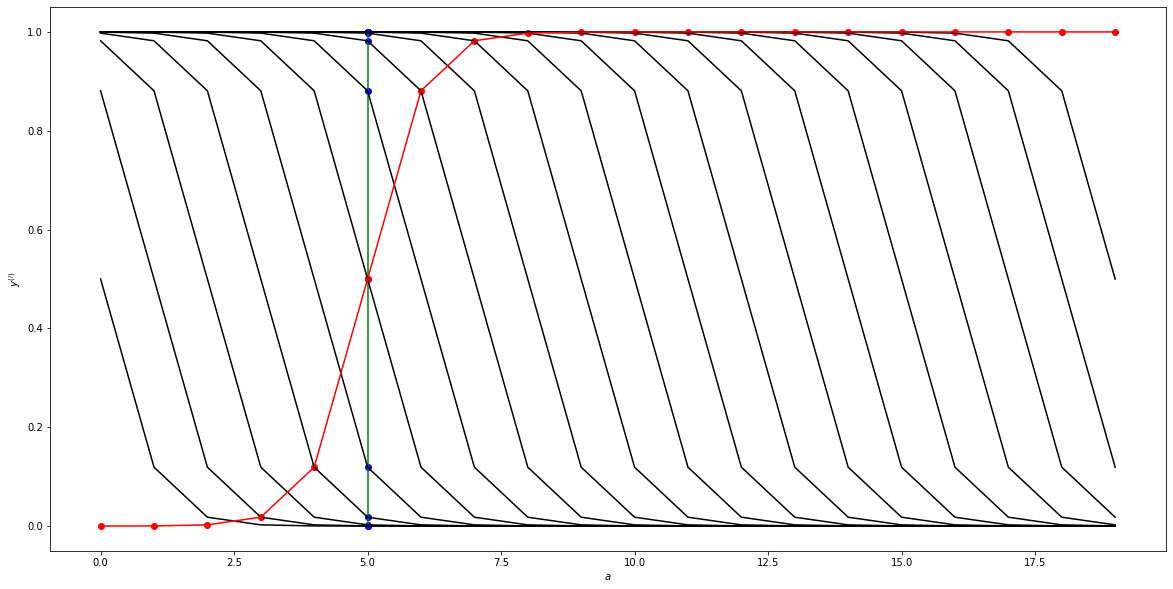

In [2]:
plt.figure(figsize=(20,10))

l = 20
z_Axis = torch.arange(0,l)

z = 5
w = 2

y =[]

for i in np.arange(l):
  sigmoid = torch.sigmoid(w*(-z_Axis + i))

  plt.plot(z_Axis, sigmoid, 'k')

  plt.scatter(z, sigmoid[z], c='b')

  y.append(sigmoid[z])

plt.vlines(z, ymin=0, ymax=1, color ='g')
plt.plot(z_Axis, y, 'r')
plt.scatter(z_Axis, y, c='r')

plt.ylabel(r'$y^{(i)}$')
plt.xlabel(r'$a$')

### Verification of the previous results

Text(0.5, 1.0, 'Step Functions')

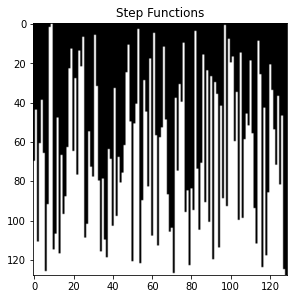

In [3]:
plt.figure(figsize=(10,5))

# Matrix of step functions
X = torch.zeros(128, 129)

r = torch.randperm(128)
X[:, r] = torch.tril(torch.ones(128, 128))

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title("Step Functions")

In [4]:
class AutoEncoder():

  def __init__(self, n_in, n_h1, n_out, hid_act = 0, out_act = 0):
    
    # Weight Initialization 
    #self.W1 = torch.randn(n_h1, n_in, dtype= torch.float)
    self.W1 = -torch.ones(n_h1, n_in, dtype= torch.float)*0.1
    #self.W1.requires_grad = True #?!

    self.b1 = 128*torch.ones(n_h1, 1, dtype = torch.float)*0.1
    #self.b1.requires_grad = True

    #self.w = - torch.randn(1, 1, dtype=torch.float)
    #self.w.requires_grad = True

    #self.W2 = -torch.randn(n_out, n_h1, dtype= torch.float)
    self.W2 =  -torch.ones(1, 1, dtype=torch.float)
    self.W2.requires_grad = True

    self.b2 = torch.randn(n_out, 1, dtype= torch.float)*0.1
    #self.b2 = torch.ones(n_out, 1, dtype= torch.float)
    #self.b2 = torch.unsqueeze(torch.arange(0,128, dtype= torch.float),1)*5
    self.b2.requires_grad = True

    # Activations
    self.hid_act = hid_act
    self.out_act = out_act

  def forward(self, X):
      z1 = self.W1 @ X + self.b1
      if self.hid_act == 0:
        self.a1 = z1
      elif self.hid_act == 1:
        self.a1 = torch.sigmoid(z1)
      else:
        self.a1 = torch.clamp(z1, min=0)

      # Output Layer
      z2 = self.W2 * torch.ones(n_out, n_h1, dtype = torch.float) @ self.a1 + self.b2
      if self.out_act == 0:
        self.y = z2
      elif self.out_act == 1:
        self.y = torch.sigmoid(z2)
      else:
        self.y = torch.clamp(z2, min =0 )    

      return self.y

  def optim_step(self, alpha = 1e-3, beta = 0):
    with torch.no_grad():

      #self.W1 -= alpha * self.W1.grad

      #self.b1 -= alpha * self.b1.grad

      self.W2 -= alpha * self.W2.grad

      #self.w -= alpha * self.w.grad

      self.b2 -= alpha * self.b2.grad
    
    #self.W1.grad.zero_()
    #self.b1.grad.zero_()
    self.W2.grad.zero_()
    #self.w.grad.zero_()
    self.b2.grad.zero_()

### a. No output activation



In [5]:
# Model Parameters
n_in = 128
n_h1 = 1
n_out = 128

# Learning Rate 
alpha = 5
# Momentum
beta = 0

# Number of epochs
nb_epochs = 10000000

In [6]:
ae = AutoEncoder(n_in, n_h1, n_out, 0, 1)

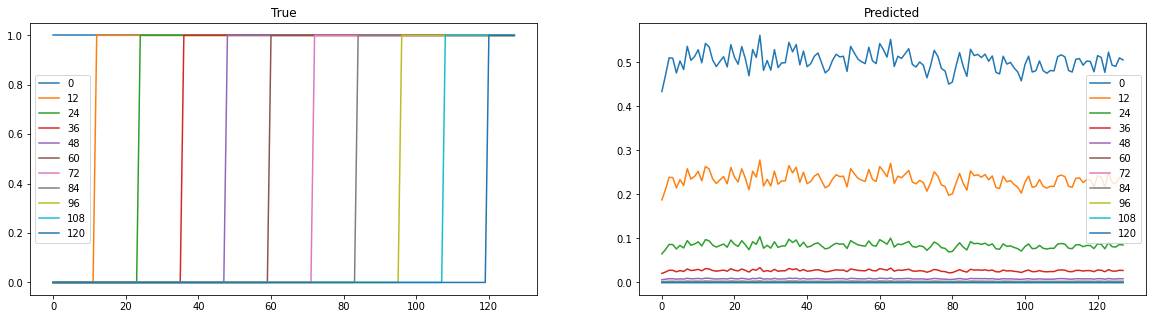

In [7]:
fig = plt.figure(figsize = (20,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 12):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("True")
axes[0].legend()
axes[1].set_title("Predicted")
axes[1].legend()

b1 = 12.800000190734863


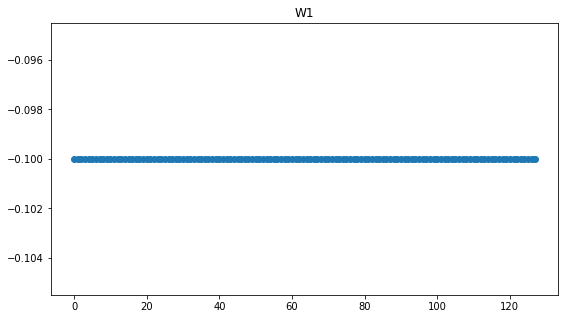

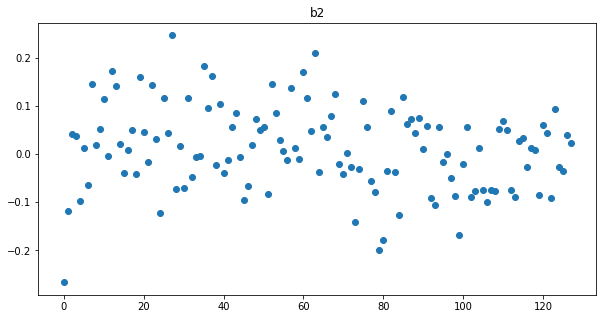

In [8]:
# Analysing the weights

plt.figure(figsize= (20,5))

plt.subplot(121)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("W1")

#plt.subplot(122)
#plt.scatter(np.arange(128), ae.W2.detach().numpy())
#plt.title("W2")

plt.figure(figsize = (10,5))
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("b2")

print(f"b1 = {ae.b1.item()}")

In [9]:
# Training

losses = []

for epoch in range(nb_epochs):
  Y = ae.forward(X)

  loss = nn.MSELoss()(Y, X)
  
  
  if (epoch + 1 )%100000 == 0:
    print(f"epoch {epoch + 1} - loss: {loss.item()}")
    losses.append(loss)
  if (epoch + 1 )%10000 == 0 and alpha<2:
    alpha = alpha*1.02

  loss.backward()

  ae.optim_step(alpha, beta)

epoch 100000 - loss: 0.02983403019607067
epoch 200000 - loss: 0.021076098084449768
epoch 300000 - loss: 0.016988607123494148
epoch 400000 - loss: 0.014399740844964981
epoch 500000 - loss: 0.012521638534963131
epoch 600000 - loss: 0.011084849014878273
epoch 700000 - loss: 0.009935838170349598
epoch 800000 - loss: 0.008976886048913002
epoch 900000 - loss: 0.008196956478059292
epoch 1000000 - loss: 0.007532867137342691
epoch 1100000 - loss: 0.006958674173802137
epoch 1200000 - loss: 0.00645908759906888
epoch 1300000 - loss: 0.00602325052022934
epoch 1400000 - loss: 0.005627818871289492
epoch 1500000 - loss: 0.005544688552618027
epoch 1600000 - loss: 0.005471135955303907
epoch 1700000 - loss: 0.005401684436947107
epoch 1800000 - loss: 0.005335569381713867
epoch 1900000 - loss: 0.005272159352898598
epoch 2000000 - loss: 0.0052103339694440365
epoch 2100000 - loss: 0.005150447599589825
epoch 2200000 - loss: 0.005092211067676544
epoch 2300000 - loss: 0.005035276524722576
epoch 2400000 - loss: 

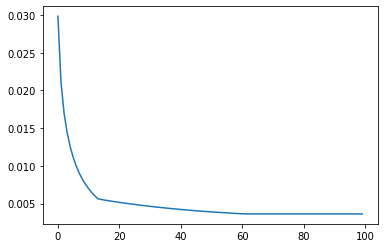

In [10]:
plt.plot(losses)

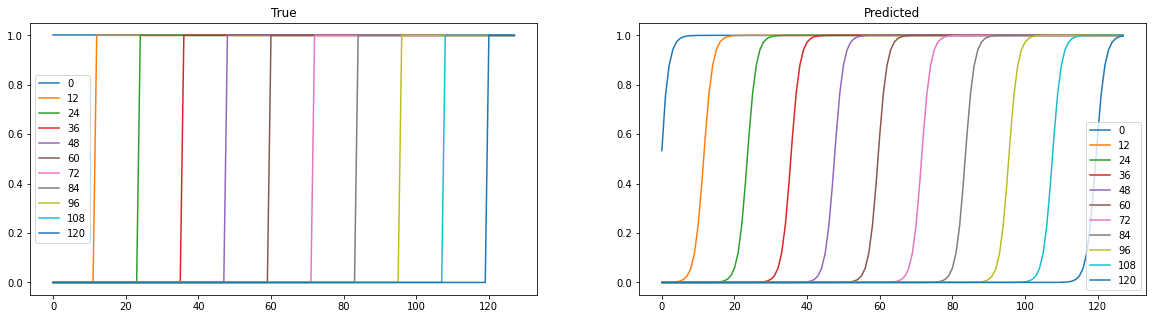

In [11]:
fig = plt.figure(figsize = (20,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 12):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("True")
axes[0].legend()
axes[1].set_title("Predicted")
axes[1].legend()

b1 = 12.800000190734863
W2 = -7.952559471130371


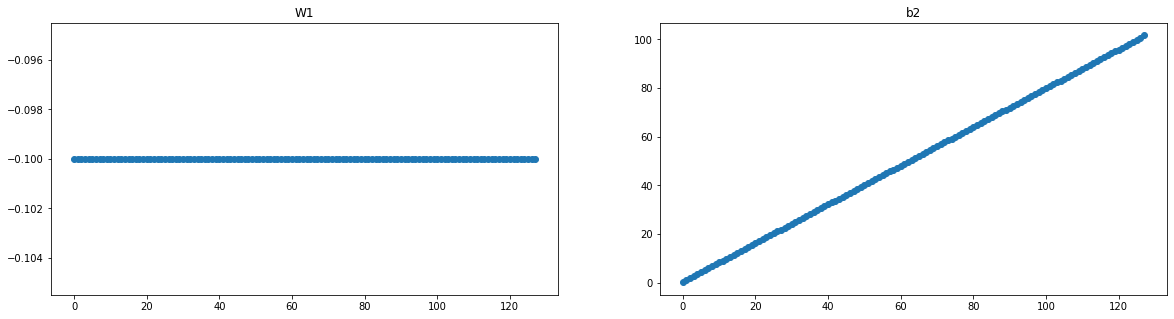

In [12]:
# Analysing the weights

plt.figure(figsize= (20,5))

plt.subplot(121)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("W1")

#plt.subplot(122)
#plt.scatter(np.arange(128), ae.W2.detach().numpy())
#plt.title("W2")

#plt.figure(figsize = (10,5))
plt.subplot(122)
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("b2")

print(f"b1 = {ae.b1.item()}")
print(f"W2 = {ae.W2.item()}")

# Two Layers AutoEncoder

We proved that a 2 layers 1 hidden neuron architecture can't correctly reproduce step functions with ReLU activations at the output. 

Since we are only interested with ReLU, we were curious to know if adding a hidden neurons can make the goal possible with only ReLU. How much hidden neurons are required if it is possible?

Let's forget the fact that we need the hidden representation to be linear and remove any constraints on $\mathbf z$.

Let $k$ be the number of neurons in the hidden layer. Let $Z$ be a $(k,n)$ matrix where the columns are the hidden representations $\mathbf z$ for the $n=128$ different positions $a$ of the step functions. The output will be 
\begin{equation}
\underset{n\times n}{Y} = g( \underset{n\times k}{W} \times \underset{k\times n}{Z})
\end{equation}

We need the preactivation matrix to be as follows.
\begin{equation} 
\underset{n\times k}{W} \times \underset{k\times n}{Z} = \underset{n\times n}{U}
\end{equation}

Where

\begin{equation}
U =
\begin{bmatrix}
    1 & u_{1,2} & u_{1,3} & \dots  & u_{1,n} \\
    1 & 1 & u_{2,3} & \dots  & u_{2,n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & 1 & 1 & \dots  & 1
\end{bmatrix}
\end{equation}

With $u_{ij} \leq 0$ $\forall i,j$ $i=1,...,n-1 $ and $j = i+1,...,n$

Now we need to prove that what we need can't be satisfied with $k \leq n$.

We start by proving that 
\begin{equation}
rank(U) = n
\end{equation}

Let $\mathbf u_i$ be the column $i$ of $U$. Let $\alpha_i$, $i=1,...,n$ be a scalar. Let's try to find these scalars such that:
\begin{equation}
\sum_{i=1}^{i=n} \alpha_i \mathbf u_i = \mathbf 0
\end{equation}
For the last entry  $u_{n,i} = 1 \forall i$, then
\begin{equation}
\sum_{i=1}^{i=n} \alpha_i = 0 \\
\alpha_n = -\sum_{i=1}^{i=n-1} \alpha_i 
\end{equation}

For the entry $n-1$,
\begin{equation}
\sum_{i=1}^{i=n-1} \alpha_i + \alpha_n u_{n-1,n}= 0 \\
-\alpha_n  + \alpha_n u_{n-1,n} = \alpha_n(u_{n-1,n} -1) =0
\end{equation}

Since $u_{i,j} \leq 1$, the only solution would be $\alpha_n = 0$. Continuing in the same manner, we'll obtain $\alpha_i = 0 \forall i=1,...,n$. 

Thus, the matrix $U$ is a full rank matrix.

Next, let's compute the rank of $W \times Z$.
\begin{align}
rank(W \times Z) & \leq min(rank(W), rank(Z)) \\
rank(W \times Z) & \leq k
\end{align}

Hence, it is possible to reconstruct the step functions if the number of hidden neurons is equal to the number of output neurons, i.e. no compression at all.

For that, we will start thinking about adding more layers while leaving the architecture symmetrical.
